In [214]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import math
import torch
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from torch import nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
sns.set_theme(style="whitegrid")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [215]:
stock_data = yf.download('TSLA',start='2015-01-01',end='2022-01-01')
stock_data_close = stock_data[['Close']]
print(stock_data_close.head(),"\nshape:",stock_data_close.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
fit_data =scaler.fit_transform(stock_data_close.values.reshape(-1,1))
#print(fit_data[:5])


[*********************100%***********************]  1 of 1 completed
                Close
Date                 
2015-01-02  14.620667
2015-01-05  14.006000
2015-01-06  14.085333
2015-01-07  14.063333
2015-01-08  14.041333 
shape: (1763, 1)


Text(0.5, 1.0, 'Stock price')

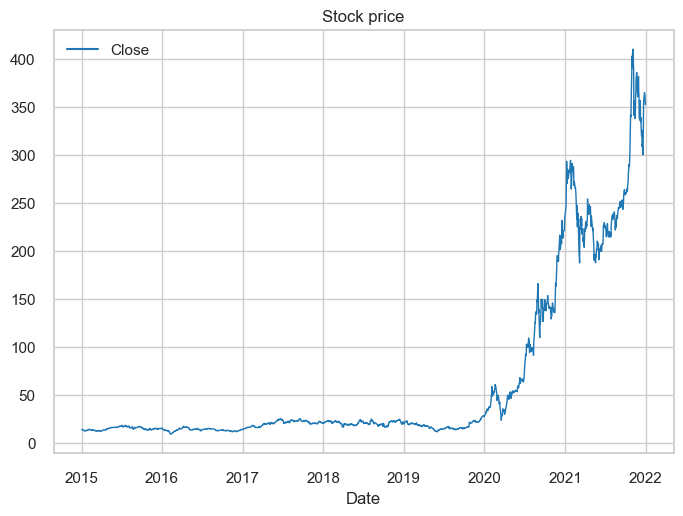

In [216]:
sns.lineplot(data = stock_data_close,palette="tab10", linewidth=1).set_title("Stock price")

In [217]:
def split_data(data,num_day):
    X,y=[],[]
    for i in range(len(data)-num_day-1):
        X.append(data[i:(i+num_day),:])
        y.append(data[i+num_day,:])
    return np.array(X),np.array(y)
num_day = 30 
X,y = split_data(fit_data,num_day)
X_train,X_test = X[:int(X.shape[0]*0.9)],X[int(X.shape[0]*0.9):]
y_train,y_test = y[:int(y.shape[0]*0.9)],y[int(y.shape[0]*0.9):]
X_train=torch.from_numpy(X_train).type(torch.Tensor).to(device)
X_test=torch.from_numpy(X_test).type(torch.Tensor).to(device)
y_train=torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test=torch.from_numpy(y_test).type(torch.Tensor).to(device)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([1558, 30, 1])
torch.Size([174, 30, 1])
torch.Size([1558, 1])
torch.Size([174, 1])


In [218]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

class LSTM (nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers, batch_first = True)
        #self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(hidden_dim,output_dim)
    
    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device="cuda")
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device="cuda")
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) 
        return out

In [219]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100,factor =0.5 ,min_lr=1e-7, eps=1e-08)
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [220]:
num_epochs = 1000
hist = np.zeros(num_epochs)
seq_dim = num_day-1 

for t in range(num_epochs): 
    y_train_pred = model(X_train)
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()    
    optimizer.zero_grad()
    loss.backward()
    scheduler.step(loss)
    optimizer.step()

Epoch  10 MSE:  0.0010021995985880494
Epoch  20 MSE:  0.0006747865118086338
Epoch  30 MSE:  0.0012105796486139297
Epoch  40 MSE:  0.0004548977594822645
Epoch  50 MSE:  0.0003905119956471026
Epoch  60 MSE:  0.0002918875543400645
Epoch  70 MSE:  0.00024088300415314734
Epoch  80 MSE:  0.00022289356274995953
Epoch  90 MSE:  0.0002040002727881074
Epoch  100 MSE:  0.0001904304517665878
Epoch  110 MSE:  0.00018062749586533755
Epoch  120 MSE:  0.00017260597087442875
Epoch  130 MSE:  0.00016573950415477157
Epoch  140 MSE:  0.00015968385559972376
Epoch  150 MSE:  0.0001542435202281922
Epoch  160 MSE:  0.0001492704323027283
Epoch  170 MSE:  0.00014465366257354617
Epoch  180 MSE:  0.0001403079368174076
Epoch  190 MSE:  0.00013616417709272355
Epoch  200 MSE:  0.00013216478691902012
Epoch  210 MSE:  0.00012826203601434827
Epoch  220 MSE:  0.00012442238221410662
Epoch  230 MSE:  0.00012063897156622261
Epoch  240 MSE:  0.00011695284774759784
Epoch  250 MSE:  0.00011346503742970526
Epoch  260 MSE:  0.0

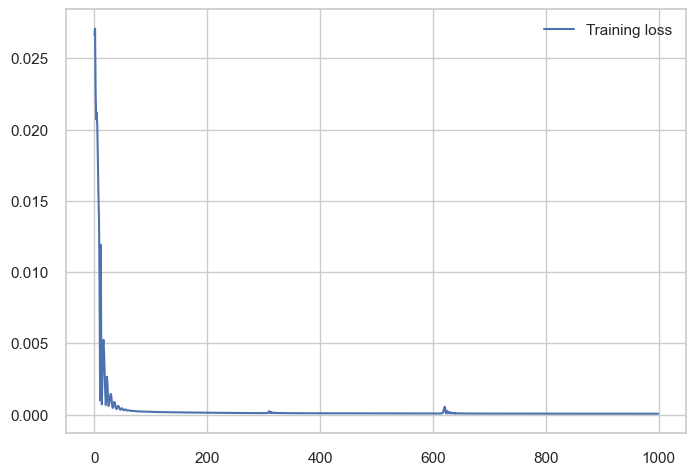

In [221]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [222]:
y_test_pred = model(X_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().to("cpu").numpy())
y_train = scaler.inverse_transform(y_train.detach().to("cpu").numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().to("cpu").numpy())
y_test = scaler.inverse_transform(y_test.detach().to("cpu").numpy())

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.18 RMSE
Test Score: 9.66 RMSE


1589


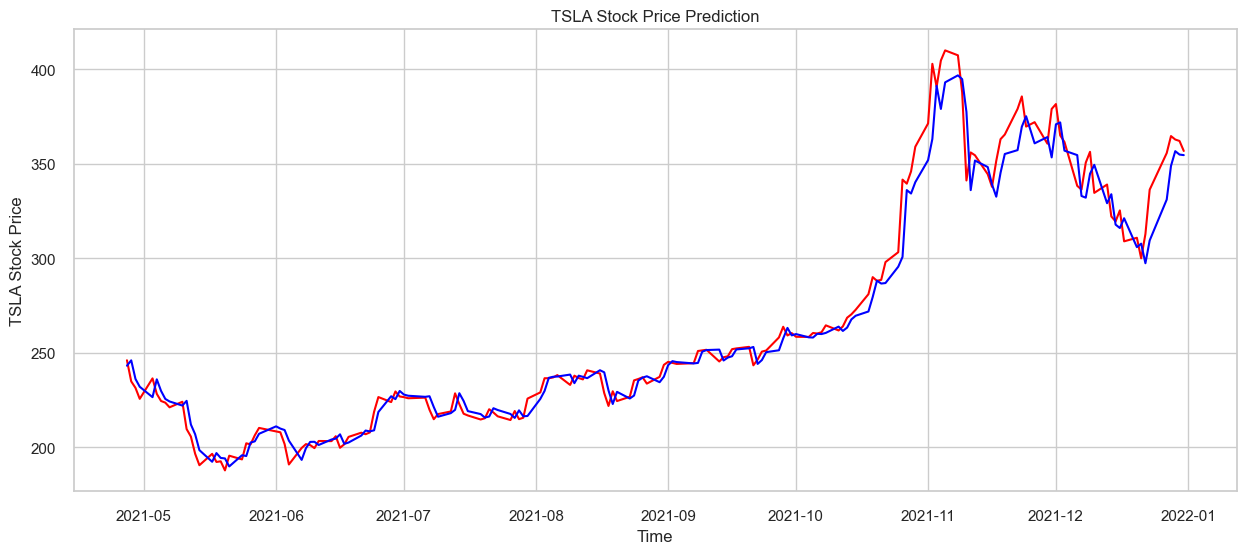

In [223]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
print(len(stock_data_close)-len(y_test))
axes.plot(stock_data_close[len(stock_data_close)-len(y_test):].index, y_test, color = 'red')
axes.plot(stock_data_close[len(stock_data_close)-len(y_test):].index, y_test_pred, color = 'blue')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.savefig('TSLA_pred.png')
plt.show()